<a href="https://colab.research.google.com/github/PaoloSani/SASP-Project/blob/main/Speech_dereverberation_using_Cepstrum_alanysis_new_with_spoken_voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import IPython.display as ipd

plt.style.use('seaborn')

# **Load the clean voice recording and the IR**




In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/SASP-Project"
%ls

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/SASP-Project'
/content
drive/  sample_data/


In [3]:
# path to the folder in drive
path = "/content/drive/MyDrive/SASP Project"

In [149]:
voice, Fs = librosa.load(path + "/Harvard list 01.wav", sr=8000)
ir, Fs_ir = librosa.load(path + "/spokane_womans_club_ir.wav", sr=None, mono=False)


In [152]:
ipd.display(ipd.Audio(voice, rate=Fs))

# **Create the new reverbered audio**

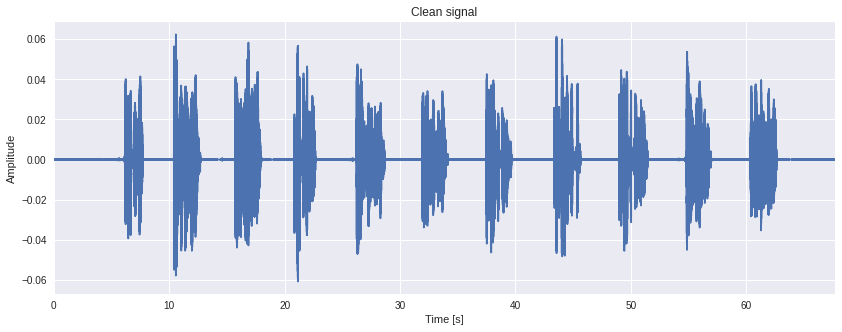

In [153]:
voice_length = voice.shape[-1]
t_instants = np.arange(0,voice_length) / Fs
final_duration = voice_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,voice)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [155]:
t_start = int(np.ceil(10.3*Fs))
t_end = int(np.ceil(12.8*Fs))
signal_dry = voice[t_start:t_end]     # shorten the original audio file

In [156]:
ipd.display(ipd.Audio(signal_dry, rate=Fs))

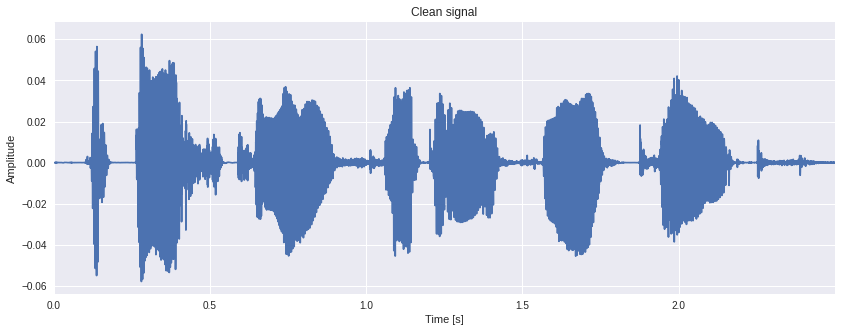

In [157]:
signal_dry_length = signal_dry.shape[-1]
t_instants = np.arange(0,signal_dry_length) / Fs
final_duration = signal_dry_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal_dry)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

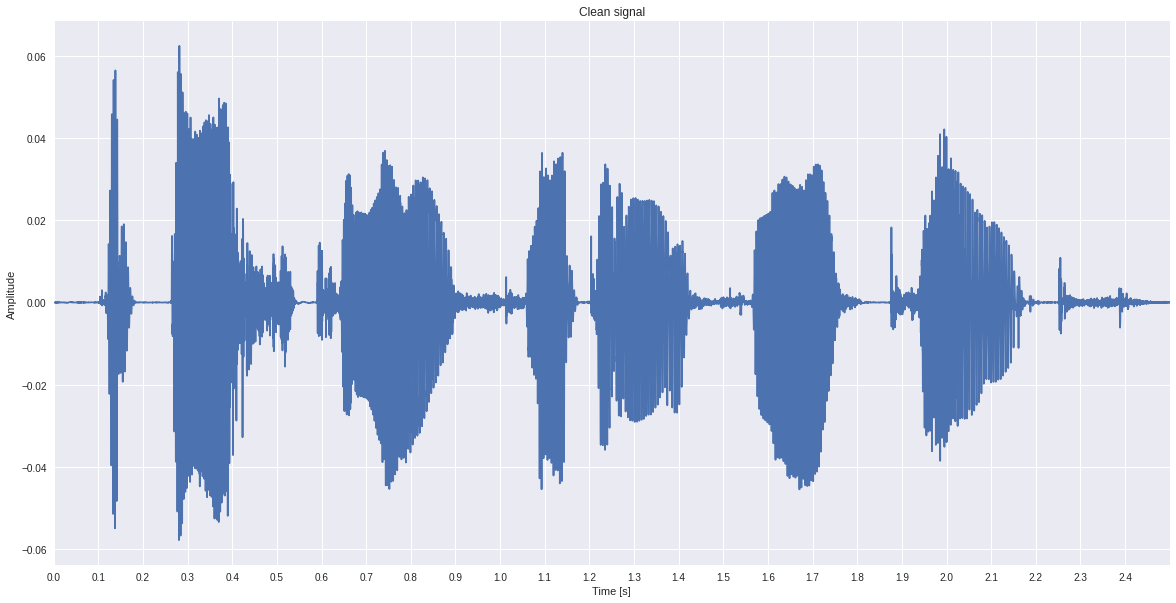

In [158]:
plt.figure(figsize=(20,10))
plt.plot(t_instants, signal_dry)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)
plt.xticks(np.arange(0, (final_duration), 0.1));


In [159]:
signal_wet = np.array([np.convolve(signal_dry, ir[0,:]),
              np.convolve(signal_dry, ir[1,:])]).T

# normalize the obtained audio
signal_wet = signal_wet / np.max(signal_wet)

# shorten the file 
t_end = int(np.ceil(4.4*Fs))
signal_wet = signal_wet[0:t_end]
signal_wet.shape 


(35200, 2)

In [160]:
ipd.display(ipd.Audio(signal_wet.T, rate=Fs))

Finally, save the new reverbered file:


In [161]:
import soundfile as sf
sf.write(path+"/reverbered_voice_new.wav", signal_wet, samplerate=Fs)

#**Simulate a RIR**


In [19]:
% pip install pyroomacoustics



     |████████████████████████████████| 1.1 MB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.5.0-cp37-cp37m-linux_x86_64.whl size=9720472 sha256=3d67c4d9d54afbf477ae3b1066697c451e9adcb6a915e21bd882b3813c0f8402
  Stored in directory: /root/.cache/pip/wheels/73/30/ca/a88fac6fba8c90101f115ee4c54b4579ad908665d8b96942f5
Successfully built pyroomacoustics


The desired RT60 was 0.3
The measured RT60 is 0.402875


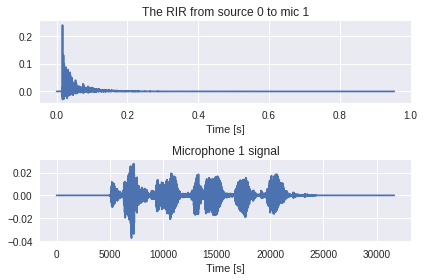

In [162]:
import pyroomacoustics as pra
from scipy.io import wavfile

# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fs = Fs
audio = signal_dry

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

room.mic_array.to_wav(
    f"voice_rev.wav",
    norm=True,
    bitdepth=np.int16,
)


voice_rev, Fs = librosa.load("voice_rev.wav", sr=None)

ipd.display(ipd.Audio(voice_rev, rate=Fs))

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

In [163]:
signal, Fs = librosa.load("voice_rev.wav", sr=None)


In [164]:
import soundfile as sf
sf.write(path+"/sim_reverbered_voice.wav", signal, samplerate=Fs)

# **Process the audio file**

In [165]:
# file_to_load = "/reverbered_voice.wav"

file_to_load = "/sim_reverbered_voice.wav"

In [166]:
# load the audio file (as MONO)
signal, Fs = librosa.load(path +file_to_load, sr=None)

ipd.display(ipd.Audio(signal, rate=Fs))

In [167]:
t_start = int(np.ceil(0.50*Fs))
t_end = int(np.ceil(3.25*Fs))
signal = signal[t_start:t_end]

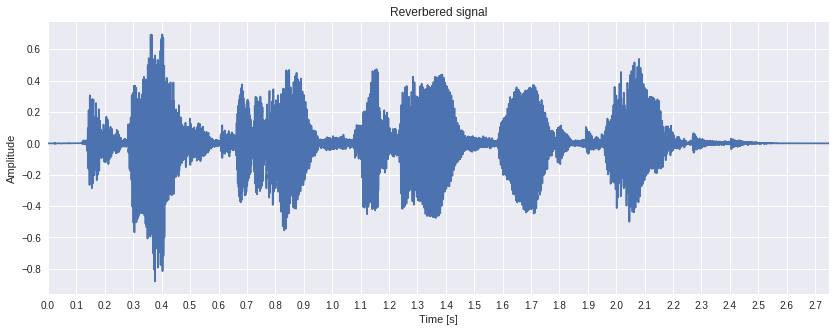

In [168]:
signal_length = len(signal)

t_instants = np.arange(0,signal_length) / Fs
final_duration = signal_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Reverbered signal');
plt.autoscale(enable=True, axis= 'x', tight =True)
plt.xticks(np.arange(0, (final_duration), 0.1));


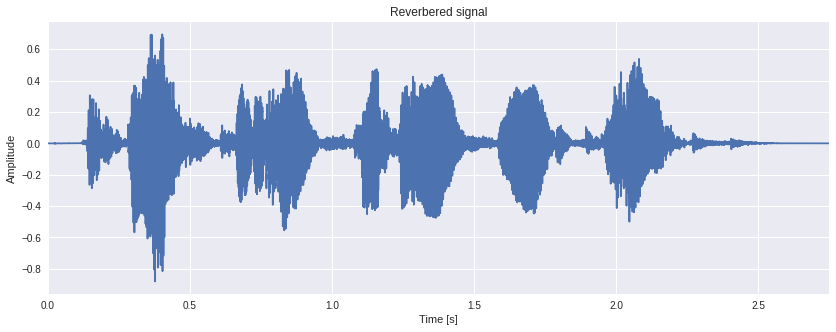

In [169]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,signal)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Reverbered signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [170]:
frame_length = 512
hop_length = 256

E_lib = librosa.feature.rms(y = signal, frame_length=frame_length, hop_length=hop_length, center= True, pad_mode='constant')
ne_frames = E_lib.shape[1]
t_e = np.arange(0, ne_frames,1)*hop_length/Fs


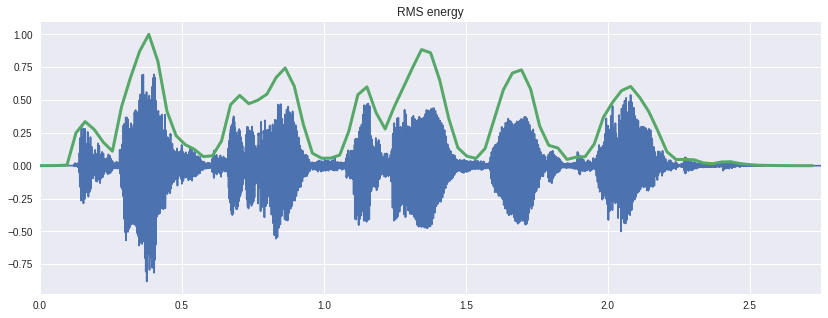

In [171]:
plt.figure(figsize=(14,5));
plt.plot(t_instants,signal)
plt.plot(t_e, E_lib[0,:]/np.max(E_lib[0,:]), linewidth=3);
plt.title("RMS energy");
plt.autoscale(enable=True, axis='x', tight=True) 

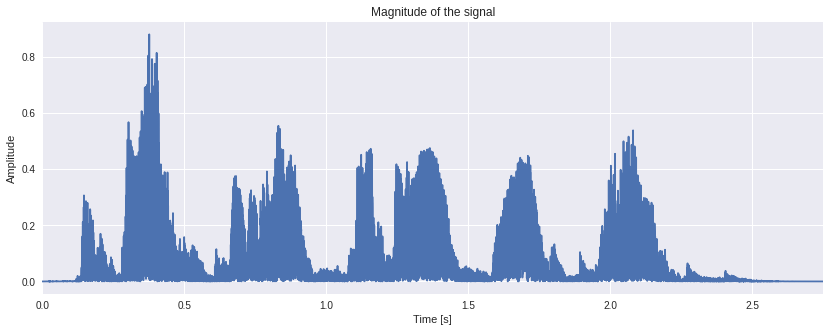

In [172]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,np.abs(signal))
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Magnitude of the signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [173]:
# SEGMENTATION by eye
segments = np.vstack([
[0.1,   0.2],
[0.25,  0.56],
[0.57,  1.07] ,
[1.08,  1.16],
[1.17,  1.56],
[1.56,  1.83],
[1.85,  2.2],
[2.25,  2.46]])
len(segments[:,0])

num_frames = segments.shape[0]
num_frames

8

In [174]:

# auxiliary function
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [175]:
limits_idx = np.zeros((num_frames,2))

start_idx = (segments[:,0]*Fs).astype(int)
stop_idx = (segments[:,1]*Fs).astype(int)
limits_idx = np.vstack([start_idx, stop_idx])
print(limits_idx) 

durations = (limits_idx[1,:] - limits_idx[0,:])

durations = list(map(nextpow2, durations))
print(durations)

max_frame_size = np.max(durations);

frames = np.zeros((num_frames,max_frame_size));
limits_idx[1,:] = limits_idx[0,:] + durations;


[[  800  2000  4560  8640  9360 12480 14800 18000]
 [ 1600  4480  8560  9280 12480 14640 17600 19680]]
[1024, 4096, 4096, 1024, 4096, 4096, 4096, 2048]


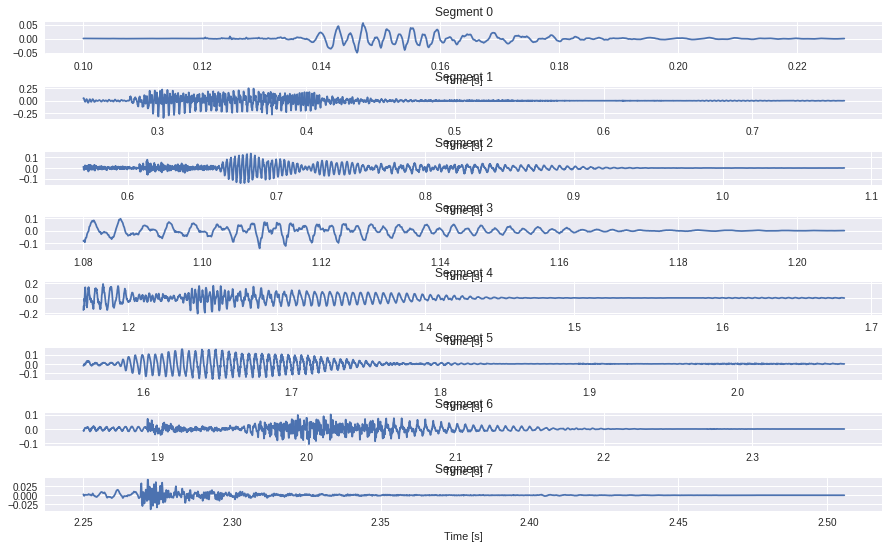

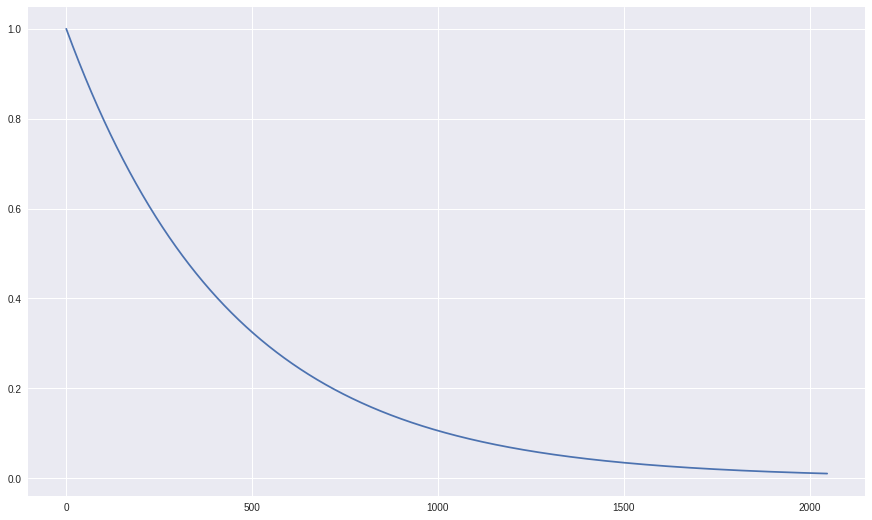

In [189]:
import scipy.signal 

plt.figure(figsize=(15,9))
for i in range(num_frames):
  plt.subplot(num_frames,1,i+1);


  t = t_instants[limits_idx[0,i] : limits_idx[1,i]];

  frame = signal[limits_idx[0,i] : limits_idx[1,i]];
  frames[i, 0:durations[i]] = frame;
  tau = 1/0.999 # scelto a caso

  tau = -(len(frame)-1) / np.log(0.01)


  win = scipy.signal.windows.exponential(len(frame),center=0, tau=tau,sym=False) # exponential asymmetric window

  frame = win*frame
  # TODO: exponential window + exponential weighting

  plt.plot(t, frame)
  plt.xlabel('Time [s]')
  plt.title('Segment {}' .format(i))
  plt.subplots_adjust(hspace=1)
  plt.subplots_adjust(wspace = 0.5)

plt.figure(figsize=(15,9))
plt.plot(win);

In [190]:
def complex_cepstrum(x, n=None):
    # """Compute the complex cepstrum of a real sequence.
         
    # Parameters
    # ----------
    # x : ndarray
    #     Real sequence to compute complex cepstrum of.
    # n : {None, int}, optional
    #     Length of the Fourier transform.
     
    # Returns
    # -------
    # ceps : ndarray
    #     The complex cepstrum of the real data sequence `x` computed using the 
    #     Fourier transform.
    # ndelay : int
    #     The amount of samples of circular delay added to `x`.
     
    # The complex cepstrum is given by
     
    # .. math:: c[n] = F^{-1}\\left{\\log_{10}{\\left(F{x[n]}\\right)}\\right}
     
    # where :math:`x_[n]` is the input signal and :math:`F` and :math:`F_{-1} 
    # are respectively the forward and backward Fourier transform.
 
    # See Also
    # --------
    # real_cepstrum: Compute the real cepstrum.
    # inverse_complex_cepstrum: Compute the inverse complex cepstrum of a real sequence.
   
   
    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples+1)//2
        if samples == 1: 
            center = 0 
        ndelay = np.array(np.round(unwrapped[...,center]/np.pi))
        unwrapped -= np.pi * ndelay[...,None] * np.arange(samples) / center
        return unwrapped, ndelay
         
    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)+np.finfo(float).eps) #+ 1j*unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real
     
    return ceps, ndelay

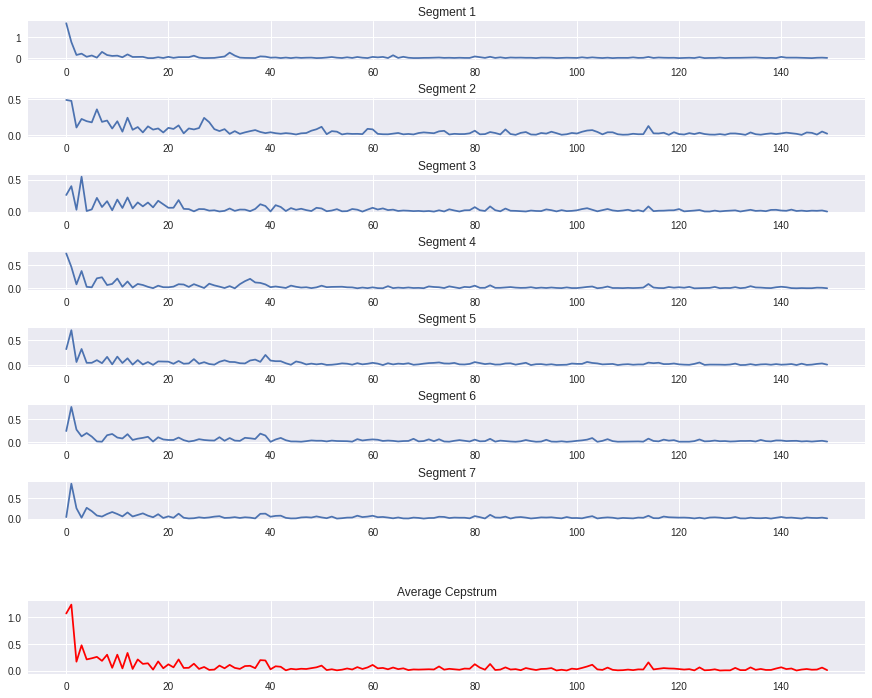

In [191]:
max_quefrency_bin = 150
avg_Cepstrum = np.zeros((num_frames, max_quefrency_bin), dtype = 'complex_')

plt.figure(figsize=(15,12))
for i in range(len(segments)):
  plt.subplot(num_frames+1,1,i+1);
  Cepstrum, _ = complex_cepstrum(frames[i, :])
  # L = len(X)
  # X = X[0 : round(L/2) + 1]
  # X_phase = np.angle(X)
  # X_phase = np.unwrap(X_phase)
  # Cepstrum = np.fft.ifft(np.log10(X))
  # TODO: unwrapping is missing

  Cepstrum = Cepstrum[0:max_quefrency_bin];
  quefrency = range(len(Cepstrum));
  plt.plot(quefrency,abs(Cepstrum))
  avg_Cepstrum[i,:] = Cepstrum;
  plt.title("Segment {}" .format(i+1));


avg_Cepstrum = np.sum(avg_Cepstrum,0)/4;
plt.subplot(5,1,5)
plt.plot(quefrency, np.abs(avg_Cepstrum), 'r');
plt.title("Average Cepstrum");
plt.subplots_adjust(hspace=1)
plt.subplots_adjust(wspace = 0.5)

In [179]:
lifter_start = 130
lifter_stop = 135

lifter = np.zeros(avg_Cepstrum.shape)

lifter[lifter_start:lifter_stop] = avg_Cepstrum[lifter_start:lifter_stop]

lifter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [146]:
full_Cepstrum, _ = complex_cepstrum(signal)

full_Cepstrum[0:max_quefrency_bin] = full_Cepstrum[0:max_quefrency_bin] - lifter

ValueError: ignored

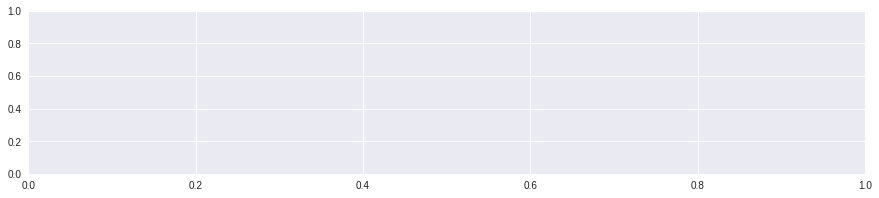

In [147]:
dereverbered_signal = np.fft.ifft(np.power(10,np.fft.fft(full_Cepstrum)))

plt.figure(6,(15,3))
plt.plot(t_instants,voice_rev)
plt.plot(t_instants,np.real(dereverbered_signal))
plt.grid('minor')

ipd.display(ipd.Audio(np.real(dereverbered_signal), rate=Fs))